## Цель: исследование объявлений о продаже квартир, установление параметров для построения автоматизированной системы, отслеживающей аномалии и мошеннические действия

### Начало исследования

#### Шаг 1. Открываю файл с данными и изучаю общую информацию

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

In [3]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 35

In [4]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

#### Шаг 2. Подготовка данных

Перевожу в int значения всех столбцов, где нет пропусков, и, где единицы измерения подразумевают целые числа

In [6]:
l = ['floors_total', 'last_price', 'balcony', 'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 
     'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'days_exposition']
for i in l:
    if data[i].isnull().sum() == 0:
        data[i] = data[i].astype('int')

In [7]:
data.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [8]:
data['days_exposition'].isnull().sum() # Срок размещения объявления

3181

Чтобы заполнить часть пропусков days_exposition, я использую медиану, сгруппированную по количеству комнат и населенному пункту.

Среднее значение days_exposition сгруппированное по населенному пункту и количеству комнат

In [9]:
days_mean = data.groupby(['locality_name', 'rooms'])['days_exposition'].mean()

In [10]:
data = data.merge(days_mean, on=['locality_name', 'rooms'], how='left', suffixes=('', '_mean'))

Замена пропусков в days_exposition средним значением

In [11]:
data.loc[data['days_exposition'].isnull(), 'days_exposition'] = \
data.loc[data['days_exposition'].isnull(), 'days_exposition_mean']

In [12]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,days_exposition_mean
0,20,13000000,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,205.682029,205.682029
1,7,3350000,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.000000,147.988372
2,10,5196000,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.000000,170.942614
3,0,64900000,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.000000,205.682029
4,2,10000000,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.000000,170.942614


In [13]:
data['days_exposition'].isna().sum()

138

In [14]:
mean = data['days_exposition'].mean()
data['days_exposition'] = data['days_exposition'].fillna(mean)

In [15]:
data = data.drop('days_exposition_mean', axis = 1)

Высота потолков

In [16]:
data['ceiling_height'].isnull().sum()

9195

In [17]:
data['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

In [18]:
def query_hist(condition, column, bins):
    return data.query(condition).hist(column, bins=bins)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fafd68e7f50>]],
      dtype=object)

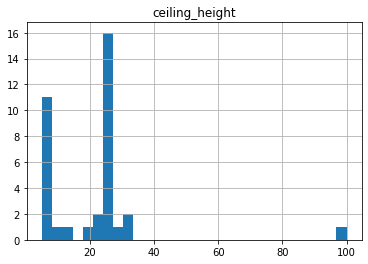

In [19]:
query_hist('ceiling_height > 5', 'ceiling_height', 30)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf9abd5710>]],
      dtype=object)

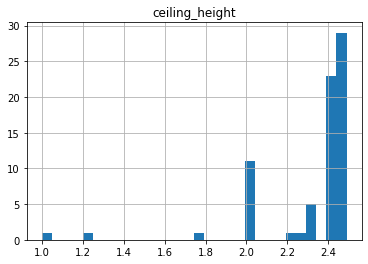

In [20]:
query_hist('ceiling_height < 2.5', 'ceiling_height', 30)

Графики для подозрительных значений больше 5 метров и меньше 2.5

In [23]:
mode_ceiling = data['ceiling_height'].mode()
mode_ceiling

0    2.5
dtype: float64

In [24]:
data.loc[data['ceiling_height'] < 2.50, 'ceiling_height'] = mode_ceiling
data.loc[data['ceiling_height'] > 5, 'ceiling_height'] = mode_ceiling

In [25]:
data['ceiling_height'] = data['ceiling_height'].fillna(2.5)

In [26]:
data['floors_total'].value_counts() # Количество этажей

5.0     5788
9.0     3761
16.0    1376
12.0    1362
4.0     1200
10.0    1174
25.0    1075
6.0      914
17.0     833
3.0      668
7.0      592
14.0     553
18.0     505
24.0     469
8.0      390
2.0      383
15.0     365
23.0     352
19.0     339
22.0     286
20.0     271
13.0     229
11.0     203
27.0     164
21.0     158
26.0     124
1.0       25
35.0      24
28.0      21
36.0       3
29.0       1
60.0       1
33.0       1
52.0       1
37.0       1
34.0       1
Name: floors_total, dtype: int64

In [27]:
data.query('floors_total > 37')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
2253,12,3800000,45.5,2018-06-28T00:00:00,2,2.88,60.0,27.4,4,NaN,False,False,7.4,NaN,Кронштадт,67763.0,49488.0,2.0,342.0,3.0,614.0,166.0
16731,9,3978000,40.0,2018-09-24T00:00:00,1,2.65,52.0,10.5,18,NaN,False,False,14.0,NaN,Санкт-Петербург,20728.0,12978.0,1.0,793.0,0.0,NaN,45.0


In [28]:
data = data.query('floors_total <= 37')

Почти все пропуски в домах с неизвестной серией. Единых значений в пределах одной серии также нет. Пропусков очень мало(0.3%), поэтому я их удаляю.

In [29]:
data = data.dropna(subset=['floors_total'])

In [30]:
data['is_apartment'].isnull().sum()

20836

In [31]:
data['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

In [32]:
data[(data['is_apartment'].isnull()) & (data['locality_name'] != 'Санкт-Петербург')].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1,7,3350000,40.40,2018-12-04T00:00:00,1,2.5,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
5,10,2890000,30.40,2018-09-10T00:00:00,1,2.5,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000,37.30,2017-11-02T00:00:00,1,2.5,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
8,20,2900000,33.16,2018-05-23T00:00:00,1,2.5,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
12,10,3890000,54.00,2016-06-30T00:00:00,2,2.5,5.0,30.00,5,NaN,False,False,9.00,0.0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,90.0


In [33]:

data[(data['is_apartment'] == False) & (data['locality_name'] != 'Санкт-Петербург')].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
11,9,3300000,44.0,2018-08-27T00:00:00,2,2.5,5.0,31.0,4,False,False,False,6.0,1.0,Ломоносов,48252.0,51677.0,0.0,NaN,0.0,NaN,7.0
42,13,22000000,161.8,2015-07-08T00:00:00,4,2.8,4.0,80.9,2,False,False,False,17.6,5.0,Петергоф,35416.0,30605.0,2.0,47.0,1.0,907.0,987.0
50,1,4500000,48.2,2017-11-13T00:00:00,1,2.7,5.0,25.4,4,False,False,False,9.0,1.0,Пушкин,19841.0,30183.0,1.0,531.0,3.0,330.0,152.0
66,6,3450000,34.0,2015-12-16T00:00:00,1,2.6,17.0,17.4,8,False,False,False,11.5,2.0,поселок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,186.0
69,6,4010000,50.7,2018-09-16T00:00:00,2,2.6,5.0,28.9,5,False,False,False,9.0,2.0,Выборг,NaN,NaN,NaN,NaN,NaN,NaN,194.0


In [34]:
data['is_apartment'] = data['is_apartment'].fillna(False)

Населенный пункт

In [35]:
data['locality_name'].isnull().sum()

48

In [36]:
data['locality_name'].value_counts()

Санкт-Петербург               15650
посёлок Мурино                  520
посёлок Шушары                  439
Всеволожск                      398
Пушкин                          369
                              ...  
деревня Новолисино                1
поселок Кирпичное                 1
деревня Большая Пустомержа        1
деревня Курковицы                 1
поселок Возрождение               1
Name: locality_name, Length: 364, dtype: int64

In [ ]:
data['locality_name'] = data['locality_name'].replace(['поселок Мурино', 'Мурино'],'посёлок Мурино') 
data['locality_name'] = data['locality_name'].replace('Кудрово','деревня Кудрово') 
data['locality_name'] = data['locality_name'].replace('поселок Бугры','посёлок Бугры')
data['locality_name'] = data['locality_name'].replace('городской посёлок Мга','посёлок городского типа Мга')

In [37]:
data = data[data['locality_name'] != 'unknown']

Жилая площадь

In [38]:
data['living_area'].isnull().sum()

1870

In [39]:
grouped = data.groupby(['rooms', 'total_area']) \
              .agg({'living_area': 'median'}) \
              .rename(columns = {'living_area': 'area_median'})


data = data.set_index(['rooms', 'total_area']).join(grouped)

data.loc[data['living_area'].isnull(), 'living_area'] = \
data.loc[data['living_area'].isnull(), 'area_median']

In [41]:
data = data.reset_index(level=['total_area', 'rooms'])

In [42]:
data = data.drop('area_median', axis = 1)


Расстояние до центра города

In [43]:
data['cityCenters_nearest'].isnull().sum()

5509

Больше всего пропусков в Питере

In [44]:
data.query('locality_name != "Санкт-Петербург" and cityCenters_nearest.isnull()')['rooms'].count()

5449

In [45]:
data.query('locality_name != "Санкт-Петербург"')['rooms'].count()

7961

In [46]:
data = data[~((data['locality_name'] == 'Санкт-Петербург') & (data['cityCenters_nearest'].isnull()))]

In [47]:
data.query('locality_name == "Санкт-Петербург" and cityCenters_nearest.isnull()')['rooms'].sum()

0

Цена

Изучаю значения столбца last_price, изменил единицу измерения на миллионы.

In [48]:
data['last_price'].describe() / 1000000

count      0.023551
mean       6.517002
std       10.858623
min        0.012190
25%        3.400000
50%        4.630000
75%        6.750000
max      763.000000
Name: last_price, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf9ac7e710>]],
      dtype=object)

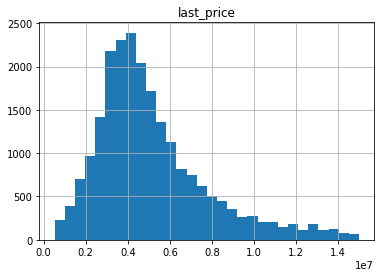

In [49]:
query_hist('500000 < last_price < 15000000', 'last_price', 30)

Добавление новых столбцов

price_sqm c ценой квадратного метра

In [50]:
data['price_sqm'] = data['last_price'] / data['total_area']
data['price_sqm'] = data['price_sqm'].astype('int')

weekday - день недели, month - месяц и year - год публикации объявления

In [51]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')

In [52]:
data['weekday'] = data['first_day_exposition'].dt.dayofweek + 1 #понедельник - первый день недели
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year

floor_type этаж, на котором расположена квартира; варианты — первый, последний, другой

In [54]:
def floor_type(row):
    floor = row['floor']
    total = row['floors_total']
    if floor == 1:
        return 'первый'
    if  floor == total:
        return 'последний'
    else:
        return 'другой'
data['floor_type'] = data.apply(floor_type, axis=1)

living_area_ratio соотношение жилой и общей площади и kitchen_area_ratio coотношение площади кухни к общей

In [55]:
data['living_area_ratio'] = round(((data['living_area'] / data['total_area']) * 100), 2)
data['kitchen_area_ratio'] = round(((data['kitchen_area'] / data['total_area']) * 100), 2)

### Задание 2. Опиcание выводов

#### 1) Каковы типичные параметры продаваемых квартир (например, площадь, цена)? Укажите наиболее важные характеристики и постройте графики.

In [56]:
data.loc[:, ['total_area', 'last_price', 'rooms', 'cityCenters_nearest']].mode()

,total_area,last_price,rooms,cityCenters_nearest
0,45.0,4500000,1,8460.0


In [57]:
data['total_area'].describe()

count    23551.000000
mean        60.267704
std         35.481348
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

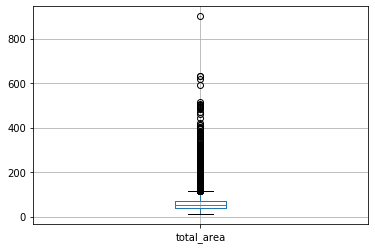

In [58]:
data.boxplot('total_area')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf96eca1d0>]],
      dtype=object)

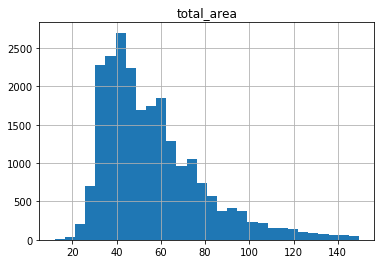

In [59]:
query_hist('total_area < 150', 'total_area', 30) # График по срезу без выбросов

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf97ecb250>]],
      dtype=object)

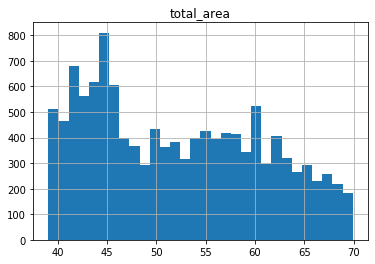

In [61]:
query_hist('39 < total_area < 70', 'total_area', 30) # График по срезу в пределах межквартильного интервала

In [62]:
data['last_price'].describe() / 1000000

count      0.023551
mean       6.517002
std       10.858623
min        0.012190
25%        3.400000
50%        4.630000
75%        6.750000
max      763.000000
Name: last_price, dtype: float64

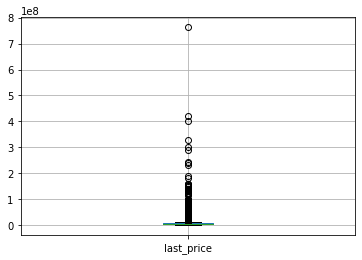

In [63]:
data.boxplot('last_price')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf97d89410>]],
      dtype=object)

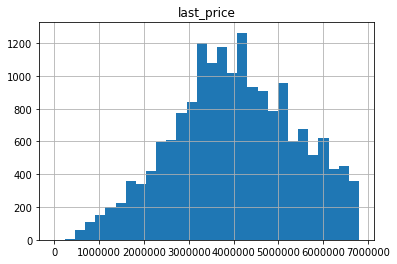

In [64]:
query_hist('last_price < 6800000', 'last_price', 30) #График распределения цены по срезу, ограниченному третьим квартилем

In [65]:
data['cityCenters_nearest'].describe()

count    18102.000000
mean     14183.200475
std       8610.606110
min        181.000000
25%       9233.250000
50%      13093.000000
75%      16285.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

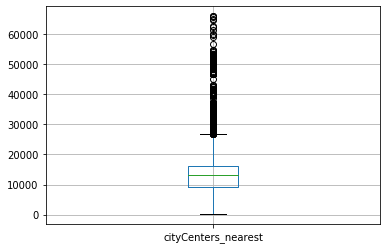

In [66]:
data.boxplot('cityCenters_nearest')

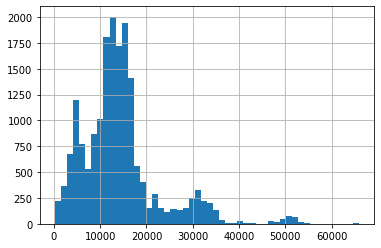

In [67]:
data['cityCenters_nearest'].hist(bins=50)

Вывод: при покупке квартиры люди в первую очередь обращают внимание на цену, общую площадь, количество комнат и расположение. В датасете больше всего двухкомнатных квартир площадью 45 кв.м. в доме типовой застройки на старой окраине города. Цена 4500000, что примерно соответствует медиане.

#### 2) Сколько обычно длится процесс продажи?

In [68]:
data.query('days_exposition > 0')['days_exposition'].describe()

count    23551.000000
mean       182.028976
std        205.714407
min          1.000000
25%         45.000000
50%        119.750000
75%        218.000000
max       1580.000000
Name: days_exposition, dtype: float64

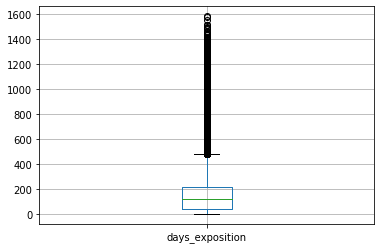

In [69]:
data.boxplot('days_exposition')

In [70]:
data.pivot_table(index = 'rooms', values = 'days_exposition', aggfunc = 'median')

,days_exposition
rooms,
0,57.000000
1,96.000000
2,115.000000
3,155.000000
4,214.500000
5,268.000000
6,285.605634
7,208.000000
8,303.000000


Вывод: наблюдается прямая зависимость между количеством комнат и длительностью экспонирования. Значительно возрастает для многокомнатных квартир с более шестью комнатами.

#### 3) Уберите квартиры с очень высокой ценой и другими необычными параметрами. Опишите, какие особенности обнаружили

In [71]:
data['last_price'].describe() / 1000000

count      0.023551
mean       6.517002
std       10.858623
min        0.012190
25%        3.400000
50%        4.630000
75%        6.750000
max      763.000000
Name: last_price, dtype: float64

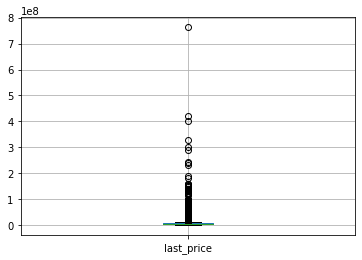

In [73]:
data.boxplot('last_price') #Много выбросов от уровня 15-20 млн

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf97abea90>]],
      dtype=object)

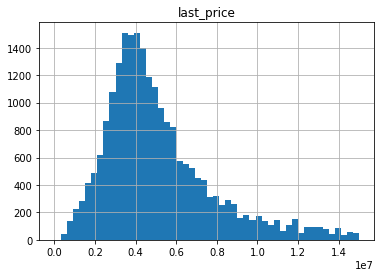

In [72]:
query_hist('last_price < 15000000', 'last_price', 50) #На уровне 15 млн значения приближаются к 0

In [74]:
1 - len(data.query('last_price < 15000000')) / len(data) #Сверхвысокие значения составляют 5%

0.052014776442613875

In [75]:
data.query('last_price < 15000000')['last_price'].describe() / 1000000

count     0.022326
mean      5.136732
std       2.680340
min       0.012190
25%       3.350000
50%       4.500000
75%       6.299000
max      14.999999
Name: last_price, dtype: float64

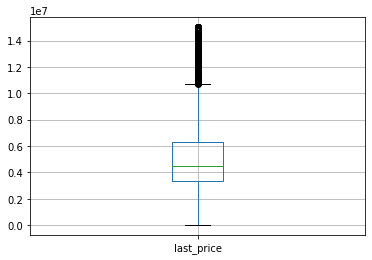

In [76]:
data.query('last_price < 15000000').boxplot('last_price')

In [77]:
data.query('last_price > 15000000')['locality_name'].value_counts() #Почти все дорогие квартиры расположены в Санкт-Петербурге, из пригородов выделяется город Пушкин

Санкт-Петербург     1143
Пушкин                18
Сестрорецк             6
посёлок Стрельна       2
Зеленогорск            2
Петергоф               2
Красное Село           1
деревня Бор            1
Кронштадт              1
Всеволожск             1
Выборг                 1
Колпино                1
посёлок Репино         1
Name: locality_name, dtype: int64

Медианное расстояние от центра для сверхдорогих квартир в 2 с лишним раза меньше, чем значение по выборке

In [78]:
data.query('last_price > 15000000')['cityCenters_nearest'].median()

5733.0

In [79]:
data['cityCenters_nearest'].median()

13093.0

In [80]:
data['total_area'].describe()

count    23551.000000
mean        60.267704
std         35.481348
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

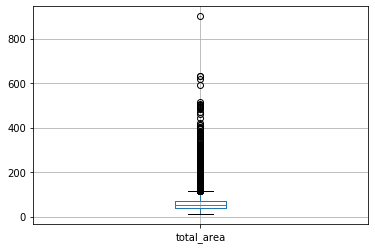

In [81]:
data.boxplot('total_area') # Много выбросов от 150 кв.м

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf9781b9d0>]],
      dtype=object)

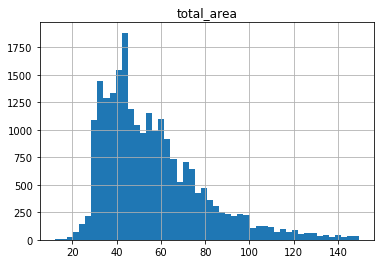

In [82]:
query_hist('total_area < 150', 'total_area', 50) # На уровне 150 кв.м значения приближаются к 0

In [83]:
1 - len(data.query('total_area < 150')) / len(data)

0.024202793936563216

Медианное расстояние от центра для квартир большой площади в 2 с лишним раза меньше, чем значение по выборке

In [84]:
data.query('total_area > 150')['cityCenters_nearest'].median()

5243.0

In [85]:
data['cityCenters_nearest'].median()

13093.0

In [86]:
data['rooms'].describe()

count    23551.000000
mean         2.070528
std          1.077227
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

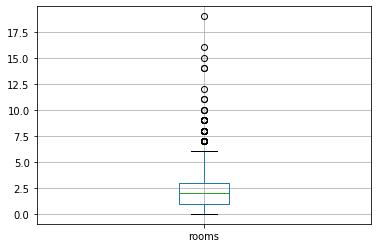

In [87]:
data.boxplot('rooms') # Некоторое количество выбросов от 6 комнат

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf9770a910>]],
      dtype=object)

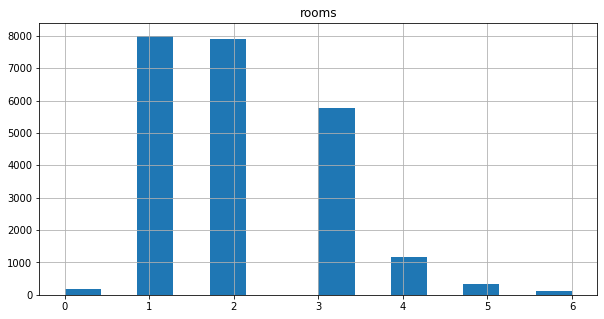

In [88]:
data.query('rooms < 7').hist('rooms', bins=14, figsize=(10,5))

In [89]:
1 - len(data.query('rooms < 7')) / len(data)

0.0037365716954693706

Вывод: в столбце last_price сверхвысокие значения превышающие 15000000 рублей составляют 5%. В столбце total_area сверхвысокие значения превышающие 150 кв.м. составляют 2%. В столбце rooms сверхвысокие значения превышающие 6 комнат составляют 0.35%. Квартиры со сверхвысокими значениями last_price и total_area расположены преимущественно в центре города.

#### 4) Какие факторы больше всего влияют на стоимость квартиры?

In [90]:
factors = [
    'last_price', 'total_area', 'rooms', 
    'floor', 'cityCenters_nearest', 'ceiling_height', 
    'floors_total', 'price_sqm', 'living_area_ratio', 
    'kitchen_area_ratio', 'weekday', 'month', 'year'
]
data.loc[:, factors].corr().sort_values(by = 'last_price', ascending=False)['last_price']

last_price             1.000000
price_sqm              0.736384
total_area             0.651447
rooms                  0.362096
ceiling_height         0.260130
floor                  0.027096
living_area_ratio      0.003452
month                  0.002432
weekday                0.001905
floors_total          -0.005973
year                  -0.043944
kitchen_area_ratio    -0.089617
cityCenters_nearest   -0.206242
Name: last_price, dtype: float64

Вывод: на стоимость квартиры влияют цена квадратного метра(корреляция 0.73), общая площадь(0.64), количество комнат(0.36).

#### 5) Зависит ли цена квадратного метра от числа комнат, этажа (первого или последнего), удалённости от центра и даты размещения: дня недели, месяца и года?

In [91]:
def first_floor(x):
    if x == 'первый':
        return True
    else:
        return False
data['first_floor'] = data['floor_type'].apply(first_floor)

In [92]:
def last_floor(x):
    if x == 'последний':
        return True
    else:
        return False
data['last_floor'] = data['floor_type'].apply(last_floor)

In [93]:
factors = [
    'price_sqm', 'rooms', 'first_floor', 
    'last_floor', 'cityCenters_nearest', 
    'weekday', 'month', 'year'
]
data.loc[:, factors].corr().sort_values(by = 'price_sqm', ascending=False)['price_sqm']

price_sqm              1.000000
rooms                  0.055252
year                   0.007159
month                 -0.001572
weekday               -0.007246
last_floor            -0.048085
first_floor           -0.129380
cityCenters_nearest   -0.317386
Name: price_sqm, dtype: float64

Вывод: цена квадратного метра зависит от расстояния от центра города(корреляция -0.31)

#### 6) Что можно сказать о цене квадратного метра в пригородах? Выберите 10 населённых пунктов с наибольшим числом объявлений.

In [94]:
(data.pivot_table(index = 'locality_name', values = 'price_sqm', aggfunc = ('count', 'median'))
     .sort_values('count', ascending = False)
     .head(11)
)

,count,median
locality_name,,
Санкт-Петербург,15590.0,104702.5
посёлок Мурино,520.0,85878.0
посёлок Шушары,439.0,76829.0
Всеволожск,398.0,65789.0
Пушкин,369.0,100000.0
Колпино,338.0,74723.5
посёлок Парголово,327.0,91642.0
Гатчина,307.0,67796.0
деревня Кудрово,299.0,91860.0


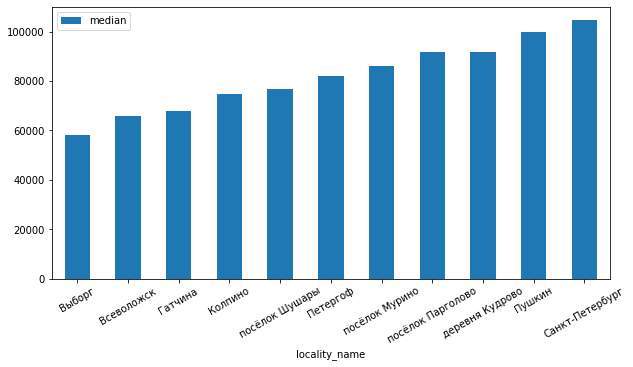

In [95]:
x = data.pivot_table(index = 'locality_name', values = 'price_sqm', 
                     aggfunc = ('count', 'median')).sort_values('count', ascending = False).head(11)
x.sort_values('median').plot(y='median', kind='bar', rot=30, figsize=(10, 5))

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


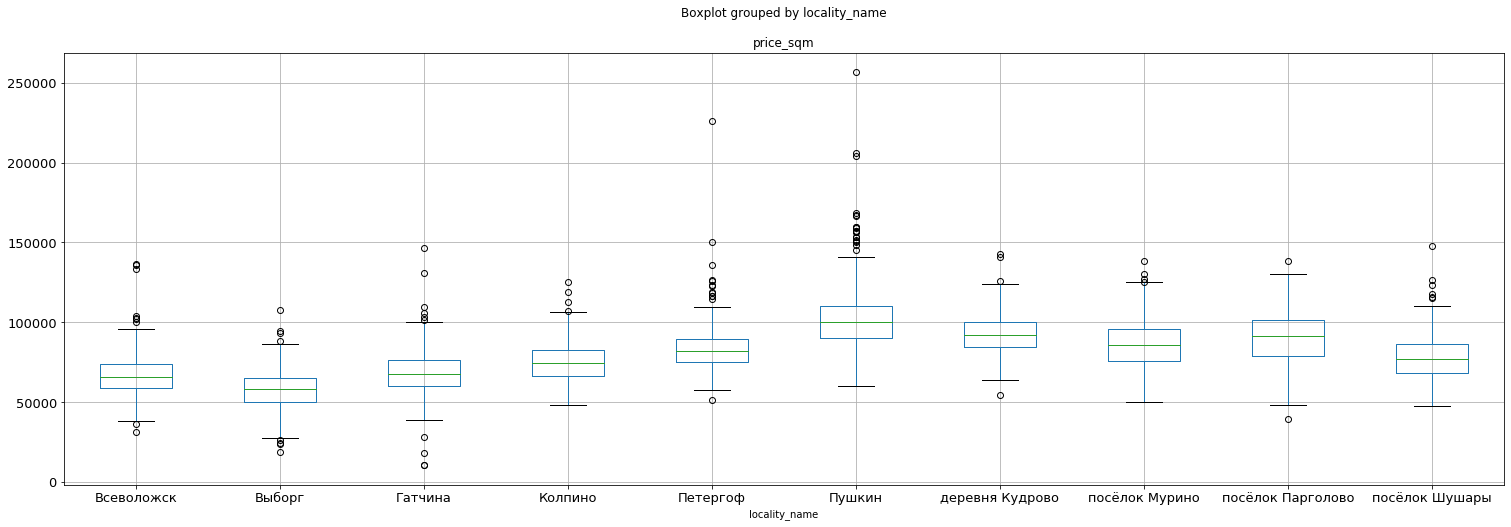

In [96]:
names = list(x.index)
data.query('locality_name in @names and locality_name != "Санкт-Петербург" and price_sqm < 300000') \
    .boxplot('price_sqm', by='locality_name', figsize=(25,8), fontsize = 13)

Вывод: медианная цена квадратного метра в городе Пушкин сопоставима с медианой в Санкт-Петербурге, хотя он достаточно удален от центра. Возможно, это можно объяснить престижностью направления(при анализе цен я отметил, что в Пушкине много квартир с высокой стоимостью, относительно пригородов). На 5-15% дешевле спальные районы - Мурино, Кудрово, Парголово. В удаленных городах Ленинградской области квадратный метр дешевле на 35-40%(Выборг, Гатчина, Всеволжск).

#### 7) Выделите сегменты типичных квартир в центре (по удалённости, числу комнат и площади) и вне центра. Границы определите самостоятельно. Выберите достаточно крупные сегменты с не менее 1000 объявлений. Сравните корреляцию основных факторов с ценой по всем предложениям и объявлениям в вашей выборке.

Исследую распределение квартир в Санкт-Петербурге в зависимости от цены и расстояния от центра

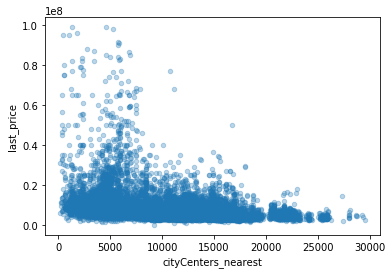

In [97]:
data.query('locality_name == "Санкт-Петербург" and last_price < 100000000') \
    .plot(x = 'cityCenters_nearest', y = 'last_price', kind = 'scatter', alpha = 0.3)

На основе графика распределения определяю границу центра 8000 метров. Создаю новый столбец со значениями True для квартир в центре и False - вне центра.

In [98]:
spb = data[data['locality_name']== "Санкт-Петербург"]
def center(x):
    if x < 8000:
        return True
    else:
        return False
spb['center'] = spb['cityCenters_nearest'].apply(center)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


График распределения квартир вне центра по количеству комнат и общей площади. Более темные участки означают большее количество объявлений

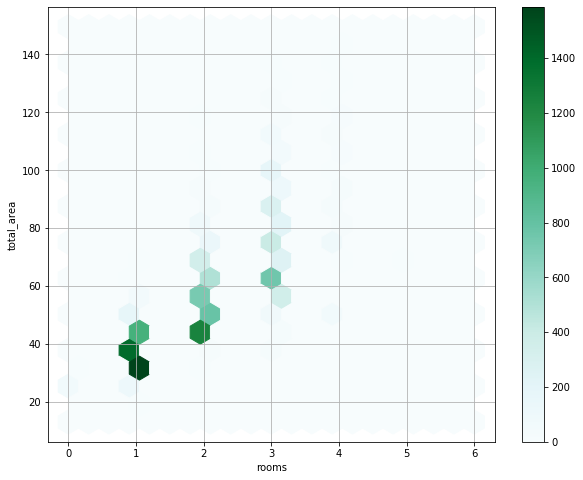

In [99]:
spb.query('rooms < 7 and total_area < 150 and center == False') \
.plot(x='rooms', y='total_area', kind='hexbin', gridsize=20, figsize=(10, 8), sharex=False, grid=True)

На основе графика распределения hexbin выделяю три сегмента квартир вне центра:

Однокомнатные квартиры площадью 30-40 метров
Двухкомнатные квартиры площадью 40-50 метров
Трехкомнатные квартиры площадью 60-80 метров

In [100]:
out1 = spb.query('rooms == 1 and 30 < total_area < 40 and center == False')
len(out1)

2533

In [101]:
out2 = spb.query('rooms == 2 and 40 < total_area < 50 and center == False')
len(out2)

1464

In [102]:
out3 = spb.query('rooms == 3 and 60 < total_area < 80 and center == False')
len(out3)

1219

График распределения квартир в центре по количеству комнат и общей площади. Более темные участки означают большее количество объявлений

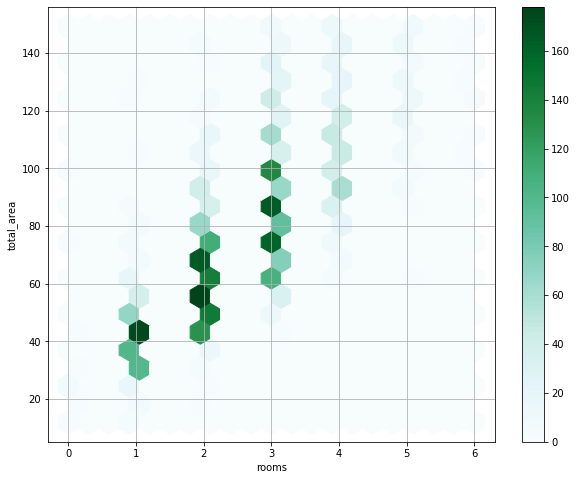

In [103]:
spb.query('rooms < 7 and total_area < 150 and center == True') \
.plot(x='rooms', y='total_area', kind='hexbin', gridsize=20, figsize=(10, 8), sharex=False, grid=True)

На основе графика распределения hexbin выделяю два сегмента квартир в центре:

Двухкомнатные квартиры площадью 35-100 метров
Трехкомнатные квартиры площадью 60-150 метров

In [104]:
in2 = spb.query('rooms == 2 and 35 < total_area < 100 and center == True')
len(in2)

1041

In [105]:
in3 = spb.query('rooms == 3 and 60 < total_area < 150 and center == True')
len(in3)

1008

Функция для построения графика корреляции основных факторов по выбранному значению

In [106]:
def corr_bar(data, value):
    """
data - датафрейм
value - столбец со значениями, по которым сранивается корреляция

Делаю срез по основным факторам, сортирую по value, строю график
"""
    return data.loc[:, [
        'last_price', 'total_area', 'floor', 
        'cityCenters_nearest', 'ceiling_height', 'floors_total', 
        'price_sqm', 'living_area_ratio', 'kitchen_area_ratio', 
        'weekday', 'month', 'year'
    ]
                   ].corr() \
                    .sort_values(by = value, ascending=False)[value] \
                    .plot(kind = 'bar', rot=30, figsize = (10, 5))

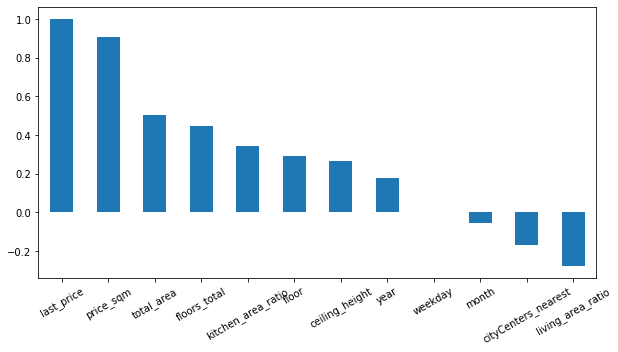

In [107]:
corr_bar(out1, 'last_price') # Строю графики корреляции основных факторов с ценой по всем сегментам и по всей выборке

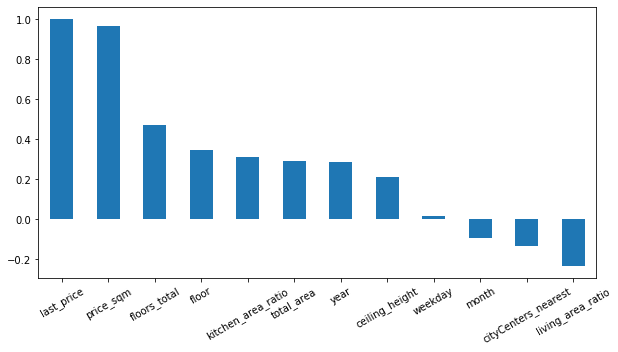

In [108]:
corr_bar(out2, 'last_price')

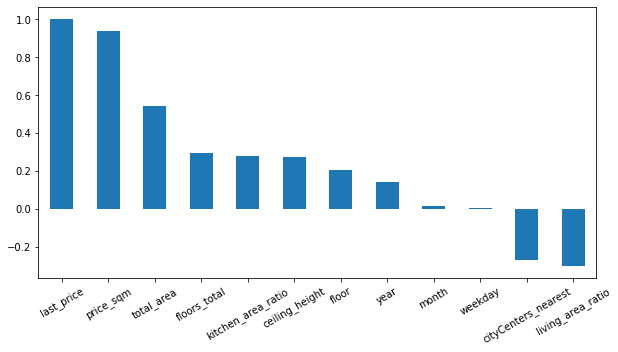

In [109]:

corr_bar(out3, 'last_price')

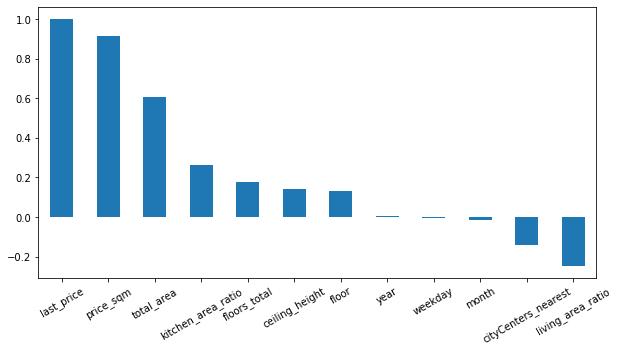

In [110]:
corr_bar(in2, 'last_price')

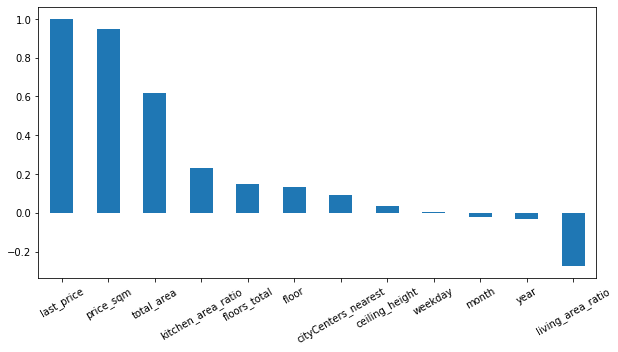

In [111]:
corr_bar(in3, 'last_price')

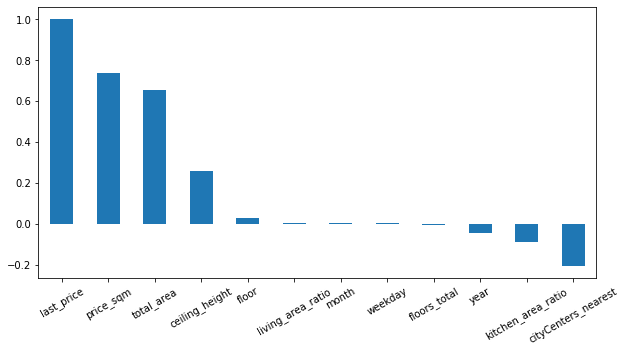

In [112]:
corr_bar(data, 'last_price')

Вывод: граница центра была определена, как 8000 метров, что соответствует локализации дорогих квартир. С другой стороны, 8000 метров это слишком большое расстояние для Санкт-Петербурга и вряд ли соответствует представлениям о центре города, но выделение меньшей области не позволяло создавать сегменты размером более 1000 объявлений в центре.

Было выделено пять сегментов:
- Однокомнатные квартиры вне центра площадью 30-40 метров - на стоимость квартиры влияют цена квадратного метра(корреляция 0.90), общая площадь(0.50), количество этажей(0.44), соотношение жилой площади к общей площади(-0.40)
- Двухкомнатные квартиры вне центра площадью 40-50 метров - на стоимость квартиры влияют цена квадратного метра(корреляция 0.96), количество этажей(0.47), этаж(0.40)
- Трехкомнатные квартиры вне центра площадью 60-80 метров - на стоимость квартиры влияют цена квадратного метра(корреляция 0.93), общая площадь(0.54), соотношение жилой площади к общей площади(-0.42)
- Двухкомнатные квартиры в центре площадью 35-100 метров - на стоимость квартиры влияют цена квадратного метра(корреляция 0.91), общая площадь(0.60), соотношение жилой площади к общей площади(-0.44)
- Двухкомнатные квартиры в центре площадью 60-150 метров - на стоимость квартиры влияют цена квадратного метра(корреляция 0.94), общая площадь(0.61)
- Для всех сегментов характерна большая зависимость стоимости квартиры от цены квадратного метра, чем по всему датасету(0.90 против 0.73). Второй сегмент выделяется большим влияние этажа(0.40)

#### 8) Подберите наиболее характерные параметры для апартаментов, студий и квартир свободной планировки. Влияют ли они на цену? Сравните со схожими параметрами квартир типовой планировки.

Характерные параметры: цена кв.м., общая площадь, цена, расстояние от центра, этаж

In [113]:
values = ['price_sqm', 'total_area', 'last_price', 'cityCenters_nearest', 'floor']


Медианные значения характерных параметров для апартаментов, сгруппированные по количеству комнат

In [114]:
data[data['is_apartment'] == True].pivot_table(index='rooms', values=values, aggfunc='median')

,cityCenters_nearest,floor,last_price,price_sqm,total_area
rooms,,,,,
1,20802.0,3,4839500,113866.5,44.95
2,16442.0,3,7500000,116900.0,70.00
3,9436.0,4,9548629,105878.0,99.00
4,NaN,2,4000000,40816.0,98.00
5,5735.0,7,84000000,165680.0,507.00
7,3876.0,2,13490000,134095.0,100.60


Функция корреляции основных параметров квартиры со значениями выбранного столбца в рамках выбранного среза

In [115]:
def corr_column(column, column_value, column_corr):
    """
    column - столбец по которому делается срез 
    column_value - значения столбца для среза
    column_corr - столбец по которому сравнивается корреляция
    """
    values = ['price_sqm', 'total_area', 'last_price', 'cityCenters_nearest', 'floor', 'rooms']
    return data[data[column] == column_value].loc[:, values].corr() \
    .sort_values(by = column_corr, ascending=False)[column_corr]


In [116]:
corr_column('is_apartment', True, 'last_price') # Корреляция основных параметров апартаментов с ценой

last_price             1.000000
total_area             0.810846
price_sqm              0.565047
rooms                  0.399182
floor                  0.119855
cityCenters_nearest   -0.447814
Name: last_price, dtype: float64

In [117]:
data[data['studio'] == True].pivot_table(index='rooms', values=values, aggfunc='median')

,cityCenters_nearest,floor,last_price,price_sqm,total_area
rooms,,,,,
0,14069.0,7,2800000,107129,26.0
1,14640.0,8,2650000,100384,27.0


In [118]:
corr_column('studio', True, 'last_price') # Корреляция основных параметров студий с ценой

last_price             1.000000
total_area             0.853751
price_sqm              0.595268
floor                 -0.049325
rooms                 -0.051094
cityCenters_nearest   -0.442744
Name: last_price, dtype: float64

Медианные значения характерных параметров для квартир свободной планировки, сгруппированные по количеству комнат

In [119]:
data[data['open_plan'] == True].pivot_table(index = 'rooms', values = values, aggfunc='median')

,cityCenters_nearest,floor,last_price,price_sqm,total_area
rooms,,,,,
0,13222.0,8.0,2600000,104285,26.10
1,13186.5,2.0,3800000,97435,39.00
2,NaN,10.0,3350000,65686,51.00
3,18113.5,2.5,4745000,76449,61.75
4,4811.0,2.0,12000000,123456,97.20
5,7101.0,5.0,48763000,310592,157.00


In [120]:

corr_column('open_plan', True, 'last_price') # Корреляция основных параметров квартир свободной планировки с ценой

last_price             1.000000
total_area             0.959663
price_sqm              0.661933
rooms                  0.388753
floor                 -0.084180
cityCenters_nearest   -0.298290
Name: last_price, dtype: float64

Медианные значения характерных параметров для квартир типовой серии 1564812, сгруппированные по количеству комнат

Вывод: наиболее характерными параметрами цену, общую площадь, количество комнат и расположение.

- Апартаменты - на стоимость квартиры влияют общая площадь(корреляция 0.81), цена квадратного метра(0.56), количество комнат(0.48), и расстояние от центра(-0.44)
- Студии - на стоимость квартиры влияют общая площадь(корреляция 0.85), цена квадратного метра(0.59) и расстояние от центра(-0.44)
- Свободная планировка - на стоимость квартиры влияют общая площадь(корреляция 0.89), цена квадратного метра(0.77) и количество комнат (0.73)
- Массовая типовая планировка 1564812 - на стоимость квартиры влияют цена квадратного метра(корреляция 0.73), общая площадь(0.67) и количество комнат (0.44)
- Основным отличие типовой планировки является преимущественное влияние цены квадратного метра. Для остальных типов жилья этим фактором будет общая площадь. Цена апартаментов и студии больше других зависит от расстоянии от центра. А на стоимость квартир свободной планировки большое влияние оказывает количество комнат.

### Общий вывод:

#### Предобработка:

- Отсутствующие значения о сроке размещения объявления были заменены средним сгруппированным по населенному пункту и количеству комнат(около 3000 значений), оставшиеся 4.5% пропусков заменены средним значением по выборке.
- Пропущенные значения серии дома были заменены на unknown(16692 значения), исправлены дубликаты.
- Отдельные ошибочные значения о высоте потолков заменены на самые частотные или близкие, пропуски заменены на самое частотное значение.
- Удалены пропуски этажности(0.3%).
- Пропуски в апартаментах заменены на значение False.
- Исправлены дубликаты в значениях населенных пунктов, удалены пропуски(0.25%).
- В значениях жилой площади 88% пропусков заполнены медианой сгруппированной по общей площади и количеству комнат.
- Удалены пропуски расстояния до центра в Санкт-Петербурге(0.3%)

Всё это может оказывать незначительное воздействие на финальные выводы.

#### Исследование:

- Проведено исследование объявлений о продаже квартир. Установлены параметры влияющие на стоимость квартиры, оценена зависимость различных факторов.
- Около 70% объявлений составляю однокомнатные и двухкомнатные квартиры. 65% продаваемых квартир расположены в Санкт-Петербурге.
- Цена квартиры увеличивается с ростом общей площади и уменьшается по мере удаления от центра.